# Random Forest Regression Model

In [4]:
import pandas as pd

# Load the datasets
file_paths = {
    "adjusted_sentiment": "Adjusted_Sentiment_Unemployment_GBPUSD.csv",
    "bond_sentiment": "Bond_Sentiment.csv",
    "ftse_sentiment": "FTSE250_Sentiment.csv",
    "gdp_sentiment": "GDP_Sentiment_MA.csv",
    "quarterly_data": "updated_quarterly_1998_v2.csv"
}

# Reading files
adjusted_sentiment_df = pd.read_csv(file_paths["adjusted_sentiment"])
bond_sentiment_df = pd.read_csv(file_paths["bond_sentiment"])
ftse_sentiment_df = pd.read_csv(file_paths["ftse_sentiment"])
gdp_sentiment_df = pd.read_csv(file_paths["gdp_sentiment"])
quarterly_data_df = pd.read_csv(file_paths["quarterly_data"])

# Displaying first few rows of each dataset
adjusted_sentiment_df.head(), bond_sentiment_df.head(), ftse_sentiment_df.head(), gdp_sentiment_df.head(), quarterly_data_df.head()


(   Unemployment_rate  finbert_score        Date
 0           7.883244      -0.196440  2009-06-30
 1           7.967259      -0.277979  2009-09-30
 2           7.899737      -0.089575  2009-12-31
 3           8.136570      -0.146002  2010-03-31
 4           8.003634      -0.112237  2010-06-30,
          Date  finbert_score  Price
 0  30/06/2009      -0.196440  3.799
 1  30/09/2009      -0.277979  3.612
 2  31/12/2009      -0.089575  3.900
 3  31/03/2010      -0.146002  3.914
 4  30/06/2010      -0.112237  3.332,
          Date  finbert_score     Price
 0  30/06/2009      -0.196440   7414.56
 1  30/09/2009      -0.277979   9142.31
 2  31/12/2009      -0.089575   9306.89
 3  31/03/2010      -0.146002  10165.28
 4  30/06/2010      -0.112237   9366.12,
          Date  finbert_score  moving_average  Rate
 0  30/06/2009      -0.196440       -0.221130  -3.5
 1  30/09/2009      -0.277979       -0.282225  -2.8
 2  31/12/2009      -0.089575       -0.235091  -2.1
 3  31/03/2010      -0.146002    

In [5]:
# Standardize date formats across all datasets
adjusted_sentiment_df['Date'] = pd.to_datetime(adjusted_sentiment_df['Date'])
bond_sentiment_df['Date'] = pd.to_datetime(bond_sentiment_df['Date'], format='%d/%m/%Y')
ftse_sentiment_df['Date'] = pd.to_datetime(ftse_sentiment_df['Date'], format='%d/%m/%Y')
gdp_sentiment_df['Date'] = pd.to_datetime(gdp_sentiment_df['Date'], format='%d/%m/%Y')
quarterly_data_df['Date'] = pd.to_datetime(quarterly_data_df['Date'], format='%d/%m/%Y')

# Merging datasets on Date column
merged_df = adjusted_sentiment_df.merge(bond_sentiment_df[['Date', 'Price']], on='Date', suffixes=('', '_bond'))
merged_df = merged_df.merge(ftse_sentiment_df[['Date', 'Price']], on='Date', suffixes=('', '_ftse'))
merged_df = merged_df.merge(gdp_sentiment_df[['Date', 'Rate']], on='Date', suffixes=('', '_gdp'))
merged_df = merged_df.merge(
    quarterly_data_df[['Date', 'Arrear (%)', 'Total Asset Purchases (GBP million)']],
    on='Date',
    suffixes=('', '_quarterly')
)

# Renaming columns for clarity
merged_df.rename(columns={
    'Price': 'Bond_Yield',
    'Price_ftse': 'FTSE_Index',
    'Rate': 'GDP_Rate',
    'Arrear (%)': 'Mortgage_Default_Rates',
    'Total Asset Purchases (GBP million)': 'Quantitative_Easing'
}, inplace=True)

# Displaying the structure of the merged data
merged_df.head()


,Unemployment_rate,finbert_score,Date,Bond_Yield,FTSE_Index,GDP_Rate,Mortgage_Default_Rates,Quantitative_Easing
0,7.883244,-0.196440,2009-06-30,3.799,7414.56,-3.5,3.547,99094
1,7.967259,-0.277979,2009-09-30,3.612,9142.31,-2.8,3.472,153770
2,7.899737,-0.089575,2009-12-31,3.900,9306.89,-2.1,3.321,190053
3,8.136570,-0.146002,2010-03-31,3.914,10165.28,2.4,3.229,199667
4,8.003634,-0.112237,2010-06-30,3.332,9366.12,3.8,3.113,199527


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Select features and target
X = merged_df[["Unemployment_rate", "Bond_Yield", "FTSE_Index", "GDP_Rate", "Mortgage_Default_Rates", "Quantitative_Easing"]]
y = merged_df["finbert_score"]

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"R-squared (R²): {r2:.3f}")

Mean Squared Error (MSE): 0.00149
R-squared (R²): 0.157


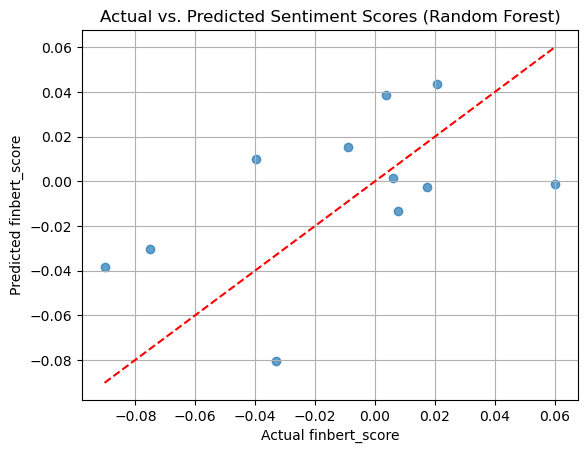

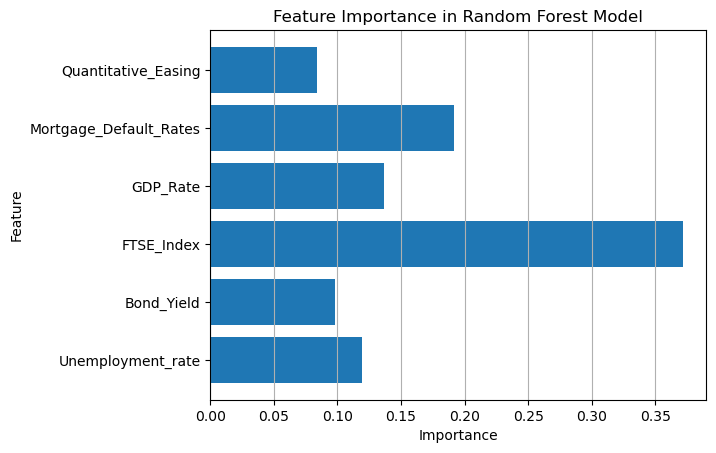

In [12]:
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

# Visualize predictions vs. actual values
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual finbert_score")
plt.ylabel("Predicted finbert_score")
plt.title("Actual vs. Predicted Sentiment Scores (Random Forest)")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.grid(True)
plt.show()


# Feature importance visualization
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a feature importance plot
plt.barh(feature_names, importances, align='center')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.grid(axis='x')
plt.show()


# Optimizing for a better rsquared score

In [13]:
from sklearn.model_selection import GridSearchCV

# Defining hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Initializing Grid Search with Random Forest Regressor
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='r2',
    n_jobs=-1,  # Utilize all available CPU cores
    verbose=1  # Display progress
)

# Fitting the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score


Fitting 3 folds for each of 486 candidates, totalling 1458 fits


({'bootstrap': True,
  'max_depth': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 100},
 0.36189596997437823)

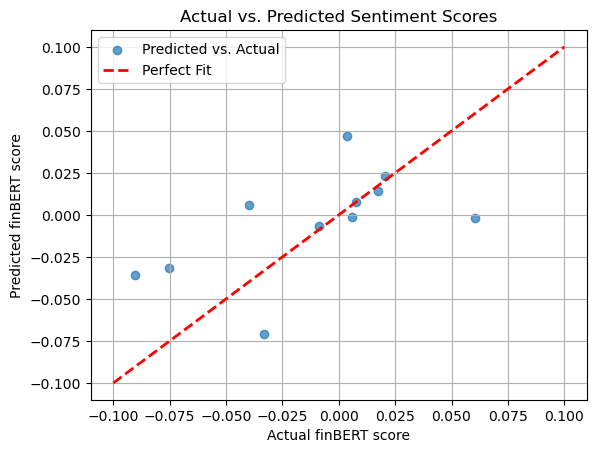

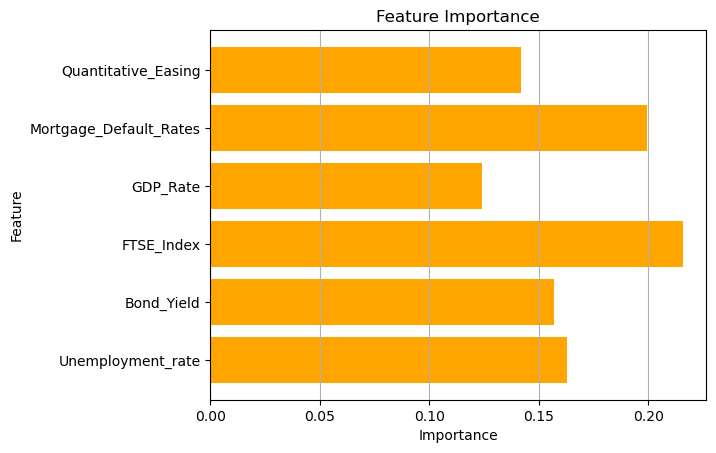

Optimized Model Evaluation:
Mean Squared Error (MSE): 0.00130
R-squared (R²): 0.265


In [17]:
# Using the best parameters from Grid Search to refit the model
optimized_rf_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    bootstrap=best_params['bootstrap'],
    random_state=42
)

# Refitting the model on the training set
optimized_rf_model.fit(X_train, y_train)

# Predictions with the optimized model
y_pred_optimized = optimized_rf_model.predict(X_test)

# Re-evaluating performance
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

# Visualizing Actual vs Predicted with optimized model
plt.scatter(y_test, y_pred_optimized, alpha=0.7, label='Predicted vs. Actual')
plt.plot([-0.1, 0.1], [-0.1, 0.1], color='red', label='Perfect Fit', linestyle='--', linewidth=2)  # 1:1 line
plt.xlabel("Actual finBERT score")
plt.ylabel("Predicted finBERT score")
plt.title("Actual vs. Predicted Sentiment Scores")
plt.legend()
plt.grid(True)
plt.show()

# Feature importance visualization for the optimized model
optimized_importances = optimized_rf_model.feature_importances_

plt.barh(feature_names, optimized_importances, align='center', color='orange')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.grid(axis='x')
plt.show()

# Print the improved evaluation metrics
print(f"Optimized Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse_optimized:.5f}")
print(f"R-squared (R²): {r2_optimized:.3f}")
